In [1]:
include("../yaoimport.jl");

# Quantum Fourier Transform 

shift gate 

shift(θ) = [ 
    1, 0 ;
    0, exp(iθ) 
]             

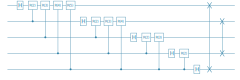

In [2]:
controlR(k) = control(k, 1=>label(shift(2π/2^k),"R($k)"))
qftblock(b) = chain(b, put(1=>H), chain(controlR(k) for k in 2:b))
qft(n) = chain(n, 
    chain(put(k:n => qftblock(n-k+1)) for k in 1:n),
    chain(swap(k,n-k+1) for k in Int.(1:(n/2)))
)

svgplot(qft(5))

# Phase Estimation

We define U(i) = U^2ⁱ as a composition of 2ⁱ gates U

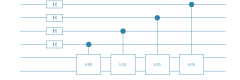

In [3]:
ublock(i,n,p,U) = chain(
    put(p-i=>H),
    control(p-i, p+1:p+n => label(matblock(U^(2^i)), "U($i)"))
)
ucircuit(n,p,U) = chain(n+p, ublock(i-1,n,p,U) for i in 1:p)
svgplot(ucircuit(2,4,rand_unitary(2^2)))

## Full Phase Estimation circuit

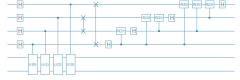

In [4]:
pecircuit(n,p,U) = chain(n+p,ucircuit(n,p,U), put(1:p => qft(p)'))
svgplot(pecircuit(2,4,rand_unitary(2^2)))

# Run the experiment

Construct a random n-qubit unitary matrix U with eigenvalues exp(2πik/2^p) for integers k and p. The precision p refers to the number of bits necessary to describe the phase

In [5]:
p = 4
n = 2

eigenvalues = [rand(0:2^p-1) for k in 1:2^n]

4-element Vector{Int64}:
  3
  3
 15
 13

In [6]:
V = rand_unitary(2^n)
U = V*Diagonal(map(k-> exp(2π*1im*k/2^p), eigenvalues))*V'

4×4 Matrix{ComplexF64}:
  0.504846-0.0369425im   0.429812+0.442339im   …   0.360438-0.317424im
 -0.565263+0.249829im    0.496072+0.49449im       -0.111268-0.0521811im
  0.048164-0.00146753im  -0.22432+0.0499666im     -0.110616-0.734248im
 -0.535761-0.2692im      0.170467-0.217058im       0.450347-0.00734329im

In [7]:
ψ = zero_state(n+p) |> pecircuit(n,p,U)

ArrayReg{2, ComplexF64, Array...}
    active qudits: 6/6
    nlevel: 2

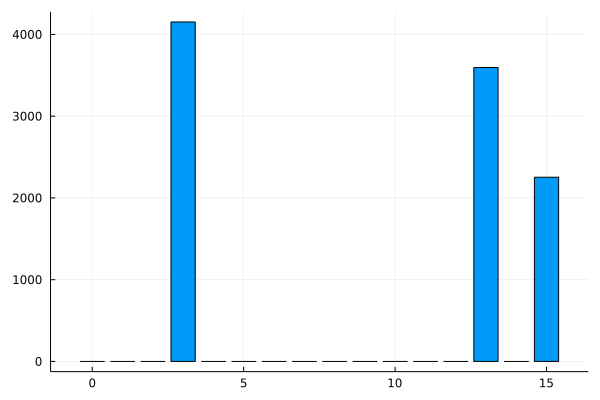

In [8]:
using Plots: bar

reversebits(x,p) = parse(Int,*(string.(digits(x; base=2,pad=p))...); base=2)

probs = measure(ψ,1:p,  nshots=10000)
counts = [(reversebits(i,p), count(==(i),Int.(probs))) for i=0:2^p-1]

bar(counts, legend=nothing)

In [9]:
sort(eigenvalues)

4-element Vector{Int64}:
  3
  3
 13
 15

The only possible outcomes are the eigenvalues of U